In [1]:
import scipy.io
import os.path as op
from mne.io import read_epochs_eeglab
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

In [2]:
pipeline='NEARICA_behav'
ages=['9m','12m','adult']

c_cluster_chans=['E16', 'E20', 'E21', 'E22','E41', 'E49', 'E50', 'E51']

plags=[2,3,4]


Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA_behav/sub-010/processed_data/sub-010_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
152 matching events found
No baseline correction applied
0 projection items activated
Ready.
9m C beta: 12.75-16.25 Hz
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/12m/derivatives/NEARICA_behav/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Ready.
12m C beta: 13.5-17.0 Hz
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/adult/derivatives/NEARICA_behav/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
194 matching events found
No baseline correction applied
0 projection items activated
Ready.
adult C beta: 18.25-24.75 Hz


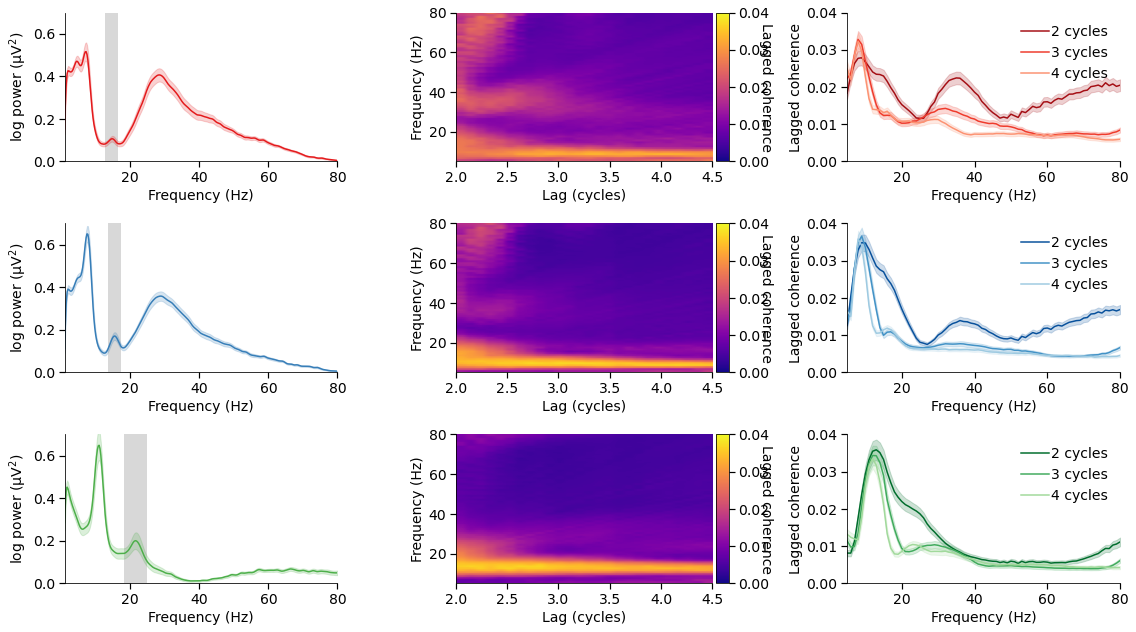

In [3]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})
   
fig=plt.figure(figsize=(16,9), facecolor='w')
gs = fig.add_gridspec(len(ages),3)

age_colors=np.array([[228,26,28],[55,126,184],[77,175,74]])/255.0
lc_colors=np.array([[[165,15,21],[239,59,44],[252,146,114]],[[8,81,156],[66,146,198],[158,202,225]],[[0,109,44],[65,171,93],[161,217,155]]])/255.0

pow_ylim=[0,0.7]
lc_ylim=[0,0.04]
for age_idx, age in enumerate(ages):
    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    subj_id=subjects['participant_id'][0]
    subject_data_fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives', pipeline, 
                               subj_id, 'processed_data', '{}_task-tool_obs_exe_eeg_processed_data.set'.format(subj_id))
                               
    EEG=read_epochs_eeglab(subject_data_fname)

    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_psd.mat')
    f = scipy.io.loadmat(fname)
    fois=f['foi_ranges']
    beta_idx=np.where(fois[:,1]<=30)[0][-1]
    c_beta_range=fois[beta_idx,:]
    print('{} C beta: {}-{} Hz'.format(age,c_beta_range[0],c_beta_range[1]))

    frex=f['frex'][0,:]
    periodic=f['periodic']
    freq_idx=np.where((frex>=1) & (frex<=80))[0]
    frex=frex[freq_idx]
    periodic=periodic[:,:,freq_idx]
    periodic[periodic<0]=0
    
    c_chan_idx=[]
    for chan in c_cluster_chans:
        c_chan_idx.append(EEG.info['ch_names'].index(chan))
        
    ax = fig.add_subplot(gs[age_idx, 0])    
    mean_resids=np.nanmean(np.nanmean(periodic[:,c_chan_idx,:],axis=1),axis=0)
    se_resids=np.nanstd(np.nanmean(periodic[:,c_chan_idx,:],axis=1),axis=0)/np.sqrt(periodic.shape[0])
    ax.plot(frex,mean_resids, color=age_colors[age_idx,:])
    ax.fill_between(frex,mean_resids-se_resids,mean_resids+se_resids, alpha=.2, color=age_colors[age_idx,:])
    mask = np.ones((100,10))
    graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
    ax.imshow(mask,cmap="gray_r", origin="lower", norm=graynorm, 
              extent=[c_beta_range[0], c_beta_range[1], pow_ylim[0], pow_ylim[1]], 
              aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim(pow_ylim)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('log power (µV$^2$)')
    
    # Load lagged coherence
    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_lagged_coherence.mat')
    f = scipy.io.loadmat(fname)
    foi=f['foi'][0,:]
    lags=f['lags'][0,:]
    lagged_coh=f['lagged_coh']
    freq_idx=np.where((foi>=5) & (foi<=80))[0]
    foi=foi[freq_idx]
    lag_idx=np.where((lags<=4.5))[0]
    lags=lags[lag_idx]
    lagged_coh=np.mean(lagged_coh[:,c_chan_idx,:,:],axis=1)
    lagged_coh=lagged_coh[:,freq_idx,:]
    lagged_coh=lagged_coh[:,:,lag_idx]

    for s in range(lagged_coh.shape[0]):
        subj_lagged_coh=lagged_coh[s,:,:]
        lagged_coh[s,:,:]=subj_lagged_coh/np.max(subj_lagged_coh[:])

    
    ax = fig.add_subplot(gs[age_idx, 1])
    i1=ax.imshow(np.mean(lagged_coh,axis=0), aspect='auto', cmap='plasma', 
                  extent=[lags[0], lags[-1], foi[0], foi[-1]], 
                  origin='lower')
    i1.set_clim(lc_ylim)
    ax.set_xlabel('Lag (cycles)')
    ax.set_ylabel('Frequency (Hz)')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb=plt.colorbar(i1, cax=cax)
    cb.set_label('Lagged coherence', rotation=270)
    
    ax = fig.add_subplot(gs[age_idx, 2])        
    for pidx, plag in enumerate(plags):
        c=lc_colors[age_idx,pidx,:]
        lag_idx=np.where((lags>=plag) & (lags<=plag+.5))[0]
        m_lc=np.nanmean(np.nanmean(lagged_coh[:,:,lag_idx],axis=2),axis=0)
        se_lc=np.nanstd(np.nanmean(lagged_coh[:,:,lag_idx],axis=2),axis=0)/np.sqrt(lagged_coh.shape[0])
        ax.plot(foi,m_lc,label='{} cycles'.format(plag),color=c)
        ax.fill_between(foi,m_lc-se_lc,m_lc+se_lc,color=c,alpha=.2)        
    ax.set_xlim(foi[[0,-1]])
    ax.set_ylim(lc_ylim)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Lagged coherence')
    ax.legend()
    
plt.tight_layout()

fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure1.svg')
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure1.png')

Extracting parameters from /home/bonaiuto/dev_beta_umd/data/9m/derivatives/NEARICA_behav/sub-010/processed_data/sub-010_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
152 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/12m/derivatives/NEARICA_behav/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /home/bonaiuto/dev_beta_umd/data/adult/derivatives/NEARICA_behav/sub-001/processed_data/sub-001_task-tool_obs_exe_eeg_processed_data.set...
Not setting metadata
194 matching events found
No baseline correction applied
0 projection items activated
Ready.


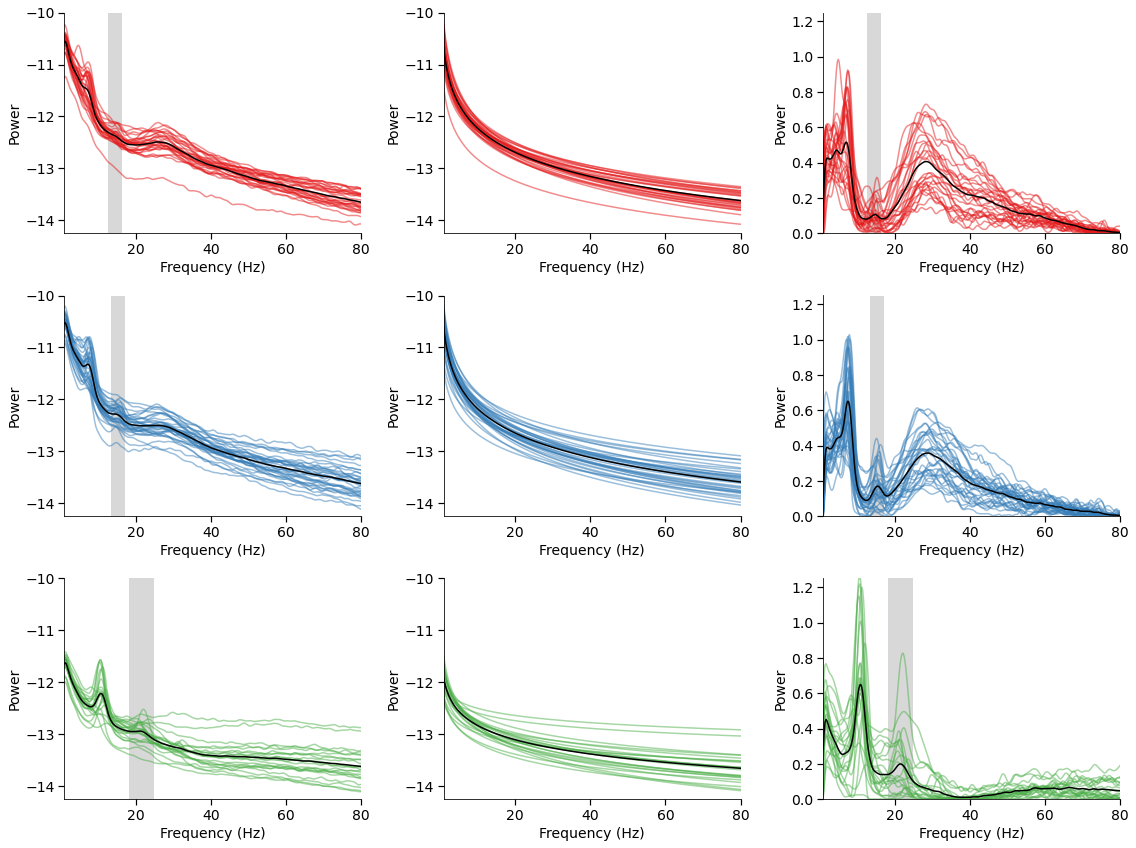

In [4]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})
fig=plt.figure(figsize=(16,12), facecolor='w')
gs = fig.add_gridspec(len(ages),3)

pow_ylim=[-14.25,-10]
periodic_ylim=[0,1.25]
age_colors=np.array([[228,26,28],[55,126,184],[77,175,74]])/255.0
for age_idx, age in enumerate(ages):
    
    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    subj_id=subjects['participant_id'][0]
    subject_data_fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives', pipeline, 
                               subj_id, 'processed_data', '{}_task-tool_obs_exe_eeg_processed_data.set'.format(subj_id))
                               
    EEG=read_epochs_eeglab(subject_data_fname)

    fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,'processed_psd.mat')
    f = scipy.io.loadmat(fname)
    frex=f['frex'][0,:]
    psd=f['psd']
    aperiodic=f['aperiodic']
    periodic=f['periodic']
    freq_idx=np.where((frex>=1) & (frex<=80))[0]
    frex=frex[freq_idx]
    psd=psd[:,:,freq_idx]
    periodic=periodic[:,:,freq_idx]
    periodic[periodic<0]=0
    aperiodic=aperiodic[:,:,freq_idx]
    fois=f['foi_ranges']
    beta_idx=np.where(fois[:,1]<=30)[0][-1]
    beta1_range=fois[beta_idx,:]    
    
    chan_idx=[]
    for chan in c_cluster_chans:
        chan_idx.append(EEG.info['ch_names'].index(chan))

    ax = fig.add_subplot(gs[age_idx, 0])
    
    for s in range(psd.shape[0]):
        ax.plot(frex,np.nanmean(np.log10(psd[s,chan_idx,:]),axis=0),color=age_colors[age_idx,:],alpha=.5)        
    ax.plot(frex,np.nanmean(np.nanmean(np.log10(psd[:,chan_idx,:]),axis=1),axis=0),color='k')        
    mask = np.ones((100,10))
    graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)
    ax.imshow(mask,cmap="gray_r", origin="lower", norm=graynorm, 
              extent=[beta1_range[0], beta1_range[1], pow_ylim[0], pow_ylim[1]], 
              aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim(pow_ylim)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
        
    ax = fig.add_subplot(gs[age_idx, 1])
    for s in range(aperiodic.shape[0]):
        ax.plot(frex,np.nanmean(aperiodic[s,chan_idx,:],axis=0),color=age_colors[age_idx,:],alpha=.5)
    ax.plot(frex,np.nanmean(np.nanmean(aperiodic[:,chan_idx,:],axis=1),axis=0),color='k')
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim(pow_ylim)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    
    ax = fig.add_subplot(gs[age_idx, 2])
    for s in range(periodic.shape[0]):
        ax.plot(frex,np.nanmean(periodic[s,chan_idx,:],axis=0),color=age_colors[age_idx,:],alpha=.5)    
    ax.plot(frex,np.nanmean(np.nanmean(periodic[:,chan_idx,:],axis=1),axis=0),color='k')    
    ax.imshow(mask,cmap="gray_r", origin="lower", norm=graynorm, 
              extent=[beta1_range[0], beta1_range[1], periodic_ylim[0], periodic_ylim[1]], 
              aspect="auto", interpolation="none",alpha=0.3, rasterized=True)
    ax.set_xlim(frex[[0,-1]])
    ax.set_ylim(periodic_ylim)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')

plt.tight_layout()
    